<a href="https://colab.research.google.com/github/kofibeans/APM1111---SA2/blob/main/AQUINO_SA2_2_Alzheimer_Mice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alzheimer's Mice: Two-Way ANOVA**

**Data Description**

Mice are used in an experiment to test drugs that may prevent Alzheimer’s disease. Half the mice are transgenic – have been genetically modified to have Alzheimer’s disease. The other half of the mice are “wild type” – they have not been modified in any way, and are considered free of Alzheimer’s disease. The mice are assigned to treatment conditions and given one of four drugs, then tested on memory using a maze. The number of errors made in the maze is recorded for the Training Day and the Memory Day.

**Directions**
1.	Analyze data using a 2-Factor (2B) ANOVA. (Just choose one of the two below. If you choose two, the other one will be considered a bonus item with a maximum of 15 points.)
  * Compare the training day errors based on drug treatments and AD status.
  * Compare the memory day errors based on drug treatments and AD status.
2.	 Check the assumptions underlying the said ANOVA type.
3.	Make a report in APA format, including the checking of the assumptions.
4.	Provide a Github link to your file answering this problem. (5 points will be automatically deducted if without a Github link.

*Note*:
* Use Jupyter Notebook or R Studio with the proper formatting of your markdown and code. You may check your results using JASP.
* Upload a Word file containing your Github link to your file or upload your R output or Python output using the tool below.
* Be sure that your outputs/files already contain the results of your analysis and I don't have to run your code to check the output results. (Minus 5 if I still have to run your code to check your outputs.)


## **Exploratory Data Analysis**

### **Environment Set-up**

The following code is written in Python. The libraries are pre-written functionality to perform necessary tasks.

In [9]:
# import libraries

# general setup and libraries
import io
import sys # access to system parameters
import os  # os-related functionalities
import numpy as np  # numerical computation
import pandas as pd  # data manipulation and statistical analysis

# data visualization
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # data visualization based on matplotlib
import pprint
import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

# statistical models and testing
import statsmodels.formula.api as smf  # statistical models using formulas
import statsmodels.api as sm  # statistical models and hypothesis testing
from scipy import stats  # scientific computing and statistical functions

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


### **Data Preparation**

#### **Import Data**

In [10]:
path = 'https://raw.githubusercontent.com/kofibeans/APM1111---SA2/main/Alzheimers%20Mice%20Data.csv'

def load(path, info = True):
  if len(path.split(".csv")) > 1:
    read = pd.read_csv(path)
  elif len(path.split(".xlsx")) > 1:
    read = pd.read_excel(path)

  if info:
    if len(read) > 0:
      print("# Dimensions")
      print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
      print("# Dtypes")
      if len(read.select_dtypes("object").columns) > 0:
        print("-- Object Variables: ",
        len(read.select_dtypes("object").columns), " ",
        read.select_dtypes("object").columns.tolist(), "")

      if len(read.select_dtypes("integer").columns) > 0:
        print("-- Integer Variables: ",
        len(read.select_dtypes("integer").columns), " ",
        read.select_dtypes("integer").columns.tolist(), "")

      if len(read.select_dtypes("float").columns) > 0:
        print("-- Float Variables:",
        len(read.select_dtypes("float").columns), " ",
        read.select_dtypes("float").columns.tolist(), "")

      if len(read.select_dtypes("bool").columns) > 0:
         print("-- Bool Variables:",
        len(read.select_dtypes("bool").columns), " ",
        read.select_dtypes("bool").columns.tolist(), "")

      print("\n# Missing Value")
      print("-- Are there any missing values? ", np.where(read.isnull().values.any() == False, "[No missing value!]", "[Data includes missing value!]"), "\n")
      buf = io.StringIO()
      read.info(buf=buf)
      info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
      print("# Memory Usage: ", info, "\n")

    else:
      print("# Data did not import!")

  return read

data = load(path, info = True)

# Dimensions
Observation: 40 Column: 4 

# Dtypes
-- Integer Variables:  4   ['AD_Status', 'Treatment', 'Training', 'Memory'] 

# Missing Value
-- Are there any missing values?  [No missing value!] 

# Memory Usage:  1.4 KB 



### **Descriptive Statistics**

In [19]:
def coefficient_of_variation(x):
    mean_value = x.mean()
    std_dev = x.std()
    if mean_value != 0:
        return (std_dev / mean_value)
    else:
        return np.nan

summary = (
    data.groupby(['Treatment', 'AD_Status'])
    .agg(
      N = ('Memory', 'count'),
      Min = ('Memory', 'min'),
      Q1 = ('Memory', lambda x: x.quantile(0.25)),
      Median = ('Memory', 'median'),
      Mean = ('Memory', np.mean),
      SD = ('Memory', 'std'),
      SE = ('Memory', lambda x: np.std(x, ddof = 1) / np.sqrt(len(x))),
      CV  =('Memory', coefficient_of_variation),
      Q3 = ('Memory', lambda x: x.quantile(0.75)),
      Max = ('Memory', 'max')
    )
)

# display the styled df
summary.style.set_precision(3)

## **Assumption Check**

The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

### **Assumptions 1 - 3**

**Assumption 1:** You have one dependent variable that is measured at the continuous level.

> ***Remark.*** The dependent variable was called `Memory` and is a continuous level.

**Assumption 2:** You have two independent variables where each independent variable consists of two or more categorical, independent groups.

> ***Remark.*** The independent variables are `AD_Status` and `Treatment`.

**Assumption 3:** You should have independence of observations.

> ***Remark.*** Each observation is independent with each other as there is no relationship between the observations in each group of the independent variable or between the groups themselves.

### **Assumption 4: Outliers**

There should be no significant outliers in the groups of your independent variable in terms of the dependent variable.

####**Outlier Detection Through Box-plot**

To visually inspect outliers through box-plots, observe the points beyond the "whiskers" of the boxplot.

<Axes: xlabel='AD_Status', ylabel='Memory'>

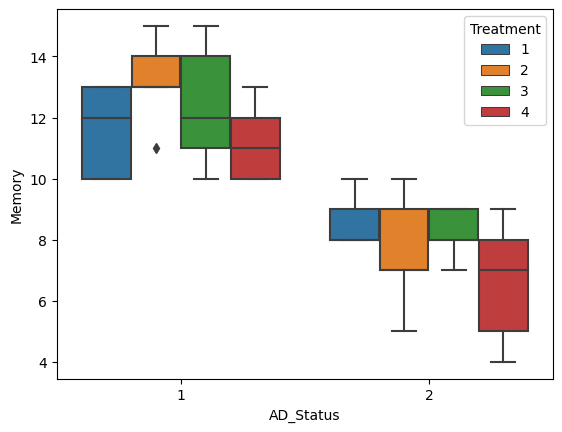

In [20]:
sns.boxplot(x = 'AD_Status', y = 'Memory', hue = 'Treatment', data = data)

####**Outlier Detection Through z-score**

To identify outliers using the z-score, we can set a threshold value by 3. Data points with a z-score greater than 3 or less than -3 can be considered an *extreme* outlier.

In [21]:
from scipy.stats import zscore

def identify_outliers(group):
    z_scores = zscore(group['Memory'])
    outliers = (z_scores > 3) | (z_scores < -3)
    return group[outliers]

outliers = data.groupby(['AD_Status', 'Treatment']).apply(identify_outliers)

# display the styled df
outliers.style

,,,AD_Status,Treatment,Training,Memory
AD_Status,Treatment,,,,,



> ***Remark.*** There were no extreme outliers.

### **Assumption 5: Normality**

Your **dependent variable** should be **approximately normally distributed for each combination of the groups of your two factors** (i.e., your within-subjects factor and between-subjects factor).

In [22]:
from scipy.stats import shapiro

# group the columns: gender, looks, personality
grouped_data = data.groupby(['AD_Status', 'Treatment'])

# initialize an empty dictionary to store the results
result_dict = {}

# perform the shapiro-wilk test for normality for each group
for group_name, group_df in grouped_data:
    result = shapiro(group_df['Memory'])
    result_dict[group_name] = {'W-statistic': result.statistic, 'p-value': result.pvalue}

# convert the dictionary to a df
result_df = pd.DataFrame(result_dict).T

# display the styled df
result_df.style


> The data was normally distributed (p \> 0.05), as assessed by Shapiro-Wilk's test of normality.

### **Assumption 6: Homogeneity of Variance**

There needs to be **homogeneity of variances for each combination of the groups of your two factors** (i.e., your within-subjects factor and between-subjects factor).

In [36]:
# group the data
group_0 = data[data['AD_Status'] == 1][data['Treatment'] == 1]['Memory']
group_1 = data[data['AD_Status'] == 1][data['Treatment'] == 2]['Memory']
group_2 = data[data['AD_Status'] == 1][data['Treatment'] == 3]['Memory']
group_3 = data[data['AD_Status'] == 1][data['Treatment'] == 4]['Memory']

group_4 = data[data['AD_Status'] == 2][data['Treatment'] == 1]['Memory']
group_5 = data[data['AD_Status'] == 2][data['Treatment'] == 2]['Memory']
group_6 = data[data['AD_Status'] == 2][data['Treatment'] == 3]['Memory']
group_7 = data[data['AD_Status'] == 2][data['Treatment'] == 4]['Memory']

# perform levene test
lt_results = stats.levene(group_0, group_1, group_2, group_3, group_4, group_5, group_6, group_7, center = 'mean')

# create a dictionary with the results
results = {
    'F': lt_results.statistic,
    'df1': [8 - 1],
    'df2': [len(group_0) + len(group_1) + len(group_2) + len(group_3) + len(group_4) + len(group_5) + len(group_6) + len(group_7) - 8],
    'p': lt_results.pvalue
}
# create a dataframe with the results
results_lt = pd.DataFrame(results)

# print and style the dataframe
print("\n Test of Equality of Variances")
results_lt.style.set_precision(3)


 Test of Equality of Variances


,F,df1,df2,p
0,1.568,7,32,0.181




> There was homogeneity of variances for all cells (p = 0.181), as assessed by Levene's test of homogeneity of variance.



## **ANOVA Testing and Computation**

In [35]:
from statsmodels.formula.api import ols

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['p_eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'p_eta_sq']
    aov = aov[cols]
    return aov

model = ols('Memory ~ AD_Status + Treatment + AD_Status:Treatment', data = data).fit()
aov_table = sm.stats.anova_lm(model, typ = 2)

# display the styled df
print("\n ANOVA")
anova_table(aov_table).style.set_precision(3)


 ANOVA


,sum_sq,df,mean_sq,F,PR(>F),p_eta_sq
AD_Status,189.225,1.000,189.225,71.511,0.000,0.646
Treatment,6.845,1.000,6.845,2.587,0.116,0.023
AD_Status:Treatment,1.445,1.000,1.445,0.546,0.465,0.005
Residual,95.260,36.000,2.646,nan,nan,nan


## **Reporting**

A two-way ANOVA was conducted to compare the memory day errors based on drug treatments and AD status. Data are mean ± standard deviation, unless otherwise stated. Residual analysis was performed to test for the assumptions of the two-way ANOVA. Outliers were assessed by inspection of a boxplot, normality was assessed using Shapiro-Wilk's normality test for each cell of the design and homogeneity of variances was assessed by Levene's test. There were no outliers, residuals were normally distributed (p > .05) and there was homogeneity of variances (p = .181). There was a statistically significant interaction between AD status and drug treatements on memory of rats, F(3, 32) = 1.151, p = .344, η2 = .220.